In [1]:
# Imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import ward, fcluster

## MetroMap Implementation

### 1. Read computed SOM

In [2]:
from SOMToolBoxParser import SOMToolBoxParser

input_vectors = SOMToolBoxParser("datasets/chainlink/chainlink.vec").read_weight_file()
weight_vectors = SOMToolBoxParser("datasets/chainlink/chainlink_small.wgt.gz").read_weight_file()

weight_vectors

{'xdim': 40,
 'ydim': 20,
 'vec_dim': 3,
 'arr': array([[-0.98806774,  1.4429287 ,  0.04905319],
        [-0.90655427,  1.37250339,  0.05000558],
        [-0.94808614,  1.32271505,  0.06845269],
        ...,
        [ 0.07295219, -0.31658632, -0.94084961],
        [ 0.05936794, -0.3673505 , -0.91611623],
        [ 0.06170286, -0.36476149, -0.86826354]])}

### 2.a Component Planes

For each unit, take the weight vector of the corresponding attribute

In [3]:
component_planes = np.array([weight_vectors['arr'][:, i] for i in range(weight_vectors['vec_dim'])]).reshape((
    weight_vectors['vec_dim'], weight_vectors['ydim'], weight_vectors['xdim']))
component_planes

array([[[-9.88067744e-01, -9.06554274e-01, -9.48086143e-01, ...,
          9.44323514e-02,  6.72223703e-02,  4.56587289e-02],
        [-9.40169540e-01, -9.29182666e-01, -9.63767380e-01, ...,
          2.82576792e-02,  3.62078562e-02,  6.14226926e-02],
        [-8.65216373e-01, -9.15055701e-01, -9.47649886e-01, ...,
         -2.17240157e-02, -4.00792549e-04,  7.95023917e-02],
        ...,
        [ 1.44067765e-01,  1.90573959e-01,  2.48811623e-01, ...,
         -1.08237568e-02,  4.48033565e-02,  7.30991842e-02],
        [ 2.02268936e-01,  2.64003682e-01,  3.77331802e-01, ...,
          2.48889138e-02,  5.34319834e-02,  6.16743961e-02],
        [ 2.49022345e-01,  3.16478029e-01,  4.42975512e-01, ...,
          7.29521912e-02,  5.93679447e-02,  6.17028558e-02]],

       [[ 1.44292870e+00,  1.37250339e+00,  1.32271505e+00, ...,
         -1.02322376e+00, -1.01394619e+00, -9.78864169e-01],
        [ 1.49443371e+00,  1.43111433e+00,  1.33190345e+00, ...,
         -9.59117822e-01, -9.93226126e

### 2.b Discretization

Input parameter `n`: number of bins

<AxesSubplot:>

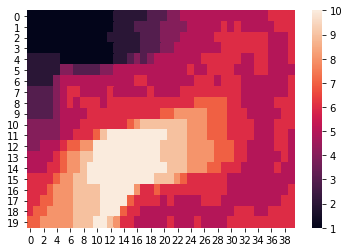

In [4]:
n = 10
discretized_planes = []

for component_plane in component_planes:
    bins = np.linspace(component_plane.min(), component_plane.max(), n, False)
    discretized_plane = np.digitize(component_plane, bins)
    discretized_planes.append(discretized_plane)

sns.heatmap(discretized_planes[0])

### 3. Component Lines (Fi)

Based on the algorith of NEU07_ijcnn, the following steps need to be performed:
For each component, take a region (bins) and check which points fall within the interval of the region. Sum the values up, and divide the sum by the number of points in the region. The result is the gravity center of a component's region. Repeat these steps for all regions.

In [5]:
def calculate_region_center(points):
    return sum(points) / len(points)


def get_points_inside_region(region, component):
    return np.argwhere(component == region)


def get_region_centers(component):
    region_centers = []
    for region_index in range(n):
        region = region_index + 1
        included_points = get_points_inside_region(region, component)
        region_center = calculate_region_center(included_points)
        region_centers.append(region_center)
    return region_centers


def get_component_lines(binned_planes):
    lines = []
    for component in binned_planes:
        region_centers = get_region_centers(component)
        lines.append(region_centers)
    return np.array(lines)


def get_high_low_lines(lines):
    lines_min_max = []
    for line in lines:
        start = line[0]
        end = line[-1]
        lines_min_max.append([start, end])
    return np.array(lines_min_max)


lines = get_component_lines(discretized_planes)
lines_min_max = get_high_low_lines(lines)

lines

array([[[ 1.83050847,  6.23728814],
        [ 3.09090909,  9.03030303],
        [ 4.61290323, 10.29032258],
        [ 6.15151515, 10.24242424],
        [ 9.17573222, 25.46443515],
        [10.25123153, 24.89162562],
        [12.57142857, 18.85714286],
        [13.95918367, 15.06122449],
        [14.15217391, 15.06521739],
        [13.95384615, 14.07692308]],

       [[ 5.08108108, 36.47297297],
        [ 7.92727273, 33.27272727],
        [ 9.58928571, 30.89285714],
        [ 8.40336134, 26.96638655],
        [ 9.59459459, 21.34234234],
        [ 9.54255319, 16.65957447],
        [10.3245614 , 11.61403509],
        [10.04255319,  8.14893617],
        [11.24      ,  5.7       ],
        [13.475     ,  2.5625    ]],

       [[16.98507463, 32.79104478],
        [15.02941176, 31.        ],
        [13.96875   , 29.21875   ],
        [12.83333333, 27.4       ],
        [10.27102804, 14.84579439],
        [ 8.47679325, 13.04219409],
        [ 5.17948718, 21.61538462],
        [ 5.2195122 , 22

## Metro Map Visualization

### 4. Visualization

Connect the centers with lines

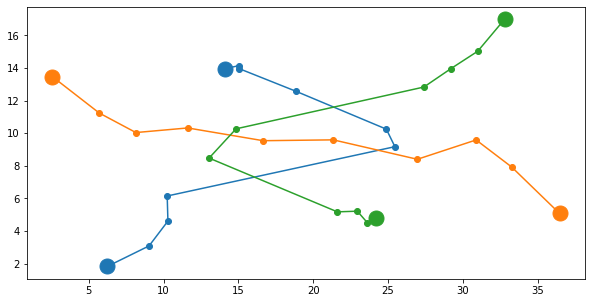

In [6]:
def visualize(lines):
    colors = iter(mcolors.TABLEAU_COLORS)
    plt.figure(figsize=(10, 5))
    for line in lines:
        color = next(colors)
        x_coordinates = [point[0] for point in line]
        y_coordinates = [point[1] for point in line]
        plt.plot(y_coordinates, x_coordinates, '-o', color=color)
        plt.plot(y_coordinates[0], x_coordinates[0], '-o', markersize = 15, color=color)
        plt.plot(y_coordinates[-1], x_coordinates[-1], '-o', markersize = 15, color=color)

    plt.show()

visualize(lines)

### 5. Aggregation (FL)

distance-based

Take pair wise lines,
    calculate distance between two lines:
        same_idx_dist <- sum of distances between pairs of centers of same indices
        inv_idx_dist <- sum of distances between paris of centers of inverted indices
        dist <- min(same_idx_dist, inv_idx_dist)

use Ward's clustering (https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html)



[[  1.           2.          96.63116106   2.        ]
 [  0.           3.         130.72348647   3.        ]]
[[[11.  34.5]
  [11.  33.5]
  [13.5 30. ]
  [12.5 29. ]
  [12.5 18. ]
  [ 9.5 15. ]
  [ 9.  17.5]
  [ 8.5 15. ]
  [ 8.5 15. ]
  [ 8.  12.5]]

 [[ 2.   6. ]
  [ 3.   7. ]
  [ 4.   8. ]
  [ 5.   9. ]
  [ 5.  25. ]
  [11.  25. ]
  [11.  19. ]
  [12.  18. ]
  [13.  17. ]
  [14.  16. ]]]


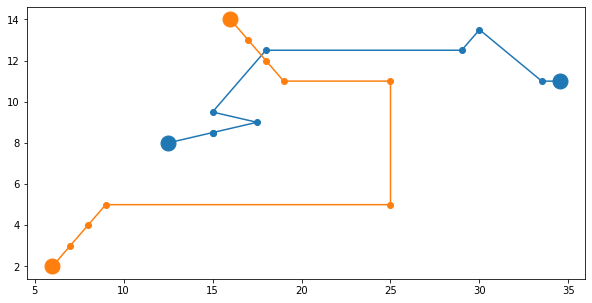

In [11]:
def distance(l1,l2,reverse_allowed=True):
    "l1 and l2 need to be 2 dimensional numpy arrays"
    distance_normal = 0
    distance_reversed = 0
    for i in range(len(l1)):
        distance_normal += np.linalg.norm(l1[i] - l2[i])
        distance_reversed += np.linalg.norm(l1[i] - l2[-(i+1)])
    l = [distance_normal, distance_reversed]
    if not reverse_allowed:
        l[1] = l[0] + 1 #add 1 to make distance the reversed distance always bigger
        
    return min(l),np.where(l == min(l))[0][0] # [0][0] to get an int instead of an array


def create_distance_matrix(lines,r,reverse_allowed=True):
    # create mattrix that shows if the pairwise distance is revesed or not
    n_lines = lines.shape[0]
    matrix = np.empty((n_lines,n_lines))
    normal_or_not = np.empty((n_lines,n_lines))
    for i in range(n_lines):
        for j in range(n_lines):
            if i == j:
                matrix[i,j] = np.inf
                normal_or_not[i,j] = -1
            else:
                matrix[i,j] = distance(lines[i],lines[j],reverse_allowed)[0]
                normal_or_not[i,j] = distance(lines[i],lines[j],reverse_allowed)[1]

    return np.triu(matrix,1), normal_or_not


def assign_clusters(d_matrix,threshold,print_Z=False):
    Z = ward(d_matrix[d_matrix > 0])
    # see link for explanation of Z
    # https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster
    if print_Z:
        print(Z)
    assigned_clusters = fcluster(Z, threshold, criterion='distance')
    return assigned_clusters

def average_lines(lines,clusters,r_matrix):
    ''' averages x,y values of all lines per cluster
    '''
    #final_lines = np.empty((clusters.max(),lines[],2))
    final_lines = []
    for i in range(max(clusters)): #iterate trough clusters
        cluster_lines = np.where(clusters == i + 1)
        if len(cluster_lines[0]) == 1:
            final_lines.append(lines[cluster_lines[0]][0].tolist())
            continue


        first_ind = cluster_lines[0][0]
        averaged_line = lines[first_ind]
        for compare_ind in cluster_lines[0]:   #itearate trough lines
            if r_matrix[first_ind, compare_ind] == 0:  # normal distance
                averaged_line = averaged_line + lines[compare_ind]

            elif r_matrix[first_ind, compare_ind] == 1:  # reverse distance
                averaged_line = averaged_line + np.flip(lines[compare_ind],axis=0)
        averaged_line = (averaged_line / len(cluster_lines[0])).tolist()

        final_lines.append(averaged_line)
    return final_lines


def aggregate(lines,threshold,print_Z=False,reverse_allowed=True):
    d_matrix, r_matrix = create_distance_matrix(lines,reverse_allowed)
    clusters = assign_clusters(d_matrix, threshold,print_Z)
    new_lines = average_lines(lines, clusters, r_matrix)
    new_lines = np.array(new_lines)

    return new_lines, clusters



agg_lines, clusters = aggregate(lines,100,True,False)
print(agg_lines)
visualize(agg_lines)

### 6. Selection

See Algorithm 1 (NEU07_wsom paper)
select only components with a small amount of regions per bin


In [8]:
def select_components(d_planes,n = 5):

    assert n <= len(d_planes), "Selection size must be smaller or equal to number of components!"

    def valid_neighbor(row, col):

            #getting dimensions
            rows = len(d_planes[0])
            cols = len(d_planes[0][0])

            return 0 <= row < rows and 0 <= col < cols

    def get_neighbors(row, col):
            for drow, dcol in [(0, 1), (0, -1), (1, 0), (-1, 0)]: #, (-1, 1), (-1, -1), (1, -1), (1, 1)]:
                nrow, ncol = row+drow, col+dcol
                if valid_neighbor(nrow, ncol):
                    yield nrow, ncol

    def get_regions_per_component(d_planes):

        #getting dimensions
        rows = len(d_planes[0])
        cols = len(d_planes[0][0])

        regions_per_component = []

        for component_plane in d_planes:
            n = component_plane.max()



            number_of_regions = 0
            for bin_value in range(1,n+1):
                regions = {}

                assigned_units = component_plane*0
                current_region_number = 1

                for row in range(len(component_plane)):
                    for col in range(len(component_plane[row])):
                        #check if unit is already assigned
                        if assigned_units[row][col] == 0 and component_plane[row][col]==bin_value:


                            assigned_neighbours = 0


                            for nrow, ncol in get_neighbors(row,col):

                                previous_assignment = assigned_units[row][col]



                                if assigned_units[nrow][ncol] != 0 and component_plane[row][col] == component_plane[nrow][ncol]:


                                    #add to neighbors region

                                    regions[assigned_units[nrow][ncol]].append((row,col))
                                    assigned_units[row][col] = assigned_units[nrow][ncol]

                                    assigned_neighbours += 1


                                    if assigned_neighbours > 1 and assigned_units[nrow][ncol] != previous_assignment:


                                        #merge
                                        regions[assigned_units[nrow][ncol]] = regions[assigned_units[nrow][ncol]] + regions[previous_assignment]

                                        #update assignment in assigned units 
                                        for tup in regions[previous_assignment]:
                                            r = tup[0]
                                            c = tup[1]
                                            assigned_units[r][c] = assigned_units[nrow][ncol]


                                        del regions[previous_assignment]





                            if assigned_neighbours == 0:



                                regions[current_region_number] = [(row,col)]
                                assigned_units[row][col] = current_region_number
                                current_region_number += 1

                # add the region count for this bin to the total           
                number_of_regions += len(regions)

            # adding the total for each component to the list  
            regions_per_component.append(number_of_regions)


        return regions_per_component
    output = []
    region_count = get_regions_per_component(d_planes)

    cut_off = sorted(region_count)[n-1]

    removed = []

    for i in range(len(region_count)):
        rem
        if region_count[i] <= cut_off:
            output.append(d_planes[i])


    return np.array(output)



### 7. Snapping

See Algorithm 1 (https://github.com/yozoon/SOM-MetroMap/blob/main/implementation_report.pdf)

See implementation of template method `_find_snapped_line`



In [9]:
def snap_component_lines(component_lines, d_planes, step):

    rows = len(d_planes[0])
    cols = len(d_planes[0][0])


    def valid_neighbor(row, col):
        return 0 <= row < rows and 0 <= col < cols

    def get_snapping_anchors(point, dist, step):
        for di in range(0,dist,step):
            for drow, dcol in [(0, 1 + di), (0, -1 - di), (1 + di, 0), (-1 - di, 0), (-1-di, 1+di), (-1-di, -1-di), (1+di, -1-di), (1+di, 1+di)]:
                        nrow, ncol = point[0]+drow, point[1]+dcol
                        if valid_neighbor(nrow,ncol):
                            yield [nrow, ncol]


    def snap_points(line, step):
        line[0] = [round(line[0][0]), round(line[0][1])]
        for i in range(len(line)-1):
            dist = round(np.linalg.norm(line[i] - line[i+1]))+1
            nearest_anchor = 0
            nearest_anchor_dist = float('inf')
            for anchor in get_snapping_anchors(line[i], dist, step):
                distance_to_anchor = np.linalg.norm(line[i+1] - anchor)
                if distance_to_anchor < nearest_anchor_dist:
                    nearest_anchor_dist = distance_to_anchor
                    nearest_anchor = anchor

            line[i+1] = nearest_anchor

        return line

    snapped_lines = []

    for c_line in component_lines:
        snapped_lines.append(snap_points(c_line, step))

    return np.array(snapped_lines)

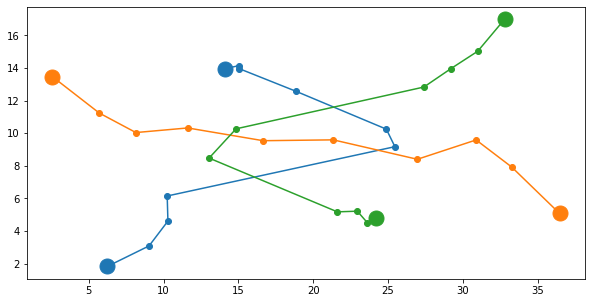

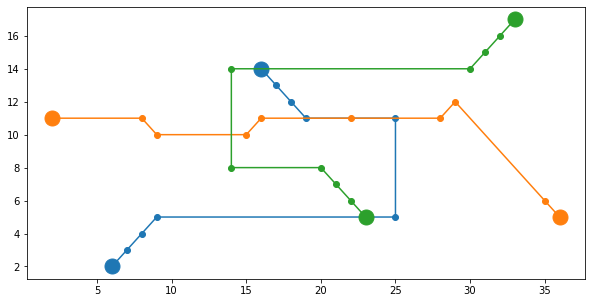

In [10]:
lines = get_component_lines(discretized_planes)
visualize(lines)
snapped_lines = snap_component_lines(lines, discretized_planes, 5)
visualize(snapped_lines)

## References